<a href="https://colab.research.google.com/github/srnarasim/DataProcessingComparison/blob/main/scenario4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenario 4: The Machine Learning Feature Pipeline

**Constraints**: Complex feature engineering, integration with ML libraries, reproducibility

This notebook demonstrates how different data processing tools handle machine learning feature engineering scenarios with:
- Complex time-based feature engineering
- Integration with ML libraries (scikit-learn, etc.)
- Reproducible feature pipelines
- Handling of different data types and transformations

We'll compare **Pandas**, **Polars**, **DuckDB**, and **Spark** for ML feature engineering workloads.

In [1]:
# Install required packages for ML feature engineering scenario
!pip install polars duckdb pyarrow scikit-learn joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries and setup
import pandas as pd
import polars as pl
import duckdb
import numpy as np
import time
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Tuple, Any

# ML libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Generate comprehensive ML dataset
def generate_ml_dataset(n_customers=50000, n_transactions_per_customer=20):
    """Generate realistic dataset for ML feature engineering"""
    np.random.seed(42)

    print(f"Generating ML dataset: {n_customers:,} customers, ~{n_transactions_per_customer} transactions each")

    # Customer demographics
    customers = []
    for i in range(n_customers):
        customer = {
            'customer_id': f"CUST_{i:06d}",
            'age': np.random.randint(18, 80),
            'gender': np.random.choice(['M', 'F'], p=[0.48, 0.52]),
            'income_bracket': np.random.choice(['Low', 'Medium', 'High'], p=[0.3, 0.5, 0.2]),
            'registration_date': datetime(2020, 1, 1) + timedelta(days=np.random.randint(0, 1460)),
            'city': np.random.choice(['NYC', 'LA', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia'], p=[0.2, 0.15, 0.1, 0.1, 0.1, 0.35]),
            'preferred_channel': np.random.choice(['Online', 'Mobile', 'Store'], p=[0.4, 0.4, 0.2])
        }
        customers.append(customer)

    customers_df = pd.DataFrame(customers)

    # Generate transactions with realistic patterns
    transactions = []
    products = [f"PROD_{i:04d}" for i in range(1, 1001)]
    categories = ['Electronics', 'Clothing', 'Books', 'Home', 'Sports', 'Beauty', 'Food', 'Automotive']

    for _, customer in customers_df.iterrows():
        # Number of transactions varies by customer characteristics
        base_transactions = n_transactions_per_customer
        if customer['income_bracket'] == 'High':
            base_transactions = int(base_transactions * 1.5)
        elif customer['income_bracket'] == 'Low':
            base_transactions = int(base_transactions * 0.7)

        n_txns = max(1, np.random.poisson(base_transactions))

        for txn_idx in range(n_txns):
            # Transaction timing patterns
            days_since_reg = (datetime.now() - customer['registration_date']).days
            txn_date = customer['registration_date'] + timedelta(
                days=np.random.randint(0, min(days_since_reg, 1460))
            )

            # Amount varies by income and category
            base_amount = np.random.lognormal(3, 1)
            if customer['income_bracket'] == 'High':
                base_amount *= 2
            elif customer['income_bracket'] == 'Low':
                base_amount *= 0.6

            category = np.random.choice(categories)
            if category == 'Electronics':
                base_amount *= 1.5
            elif category == 'Food':
                base_amount *= 0.3

            transaction = {
                'transaction_id': f"TXN_{len(transactions):08d}",
                'customer_id': customer['customer_id'],
                'product_id': np.random.choice(products),
                'product_category': category,
                'amount': round(base_amount, 2),
                'transaction_date': txn_date,
                'channel': np.random.choice(['Online', 'Mobile', 'Store'],
                                          p=[0.5, 0.3, 0.2] if customer['preferred_channel'] == 'Online' else
                                            [0.2, 0.6, 0.2] if customer['preferred_channel'] == 'Mobile' else
                                            [0.2, 0.2, 0.6]),
                'discount_applied': np.random.choice([True, False], p=[0.3, 0.7]),
                'payment_method': np.random.choice(['Credit', 'Debit', 'Cash', 'Digital'], p=[0.4, 0.3, 0.1, 0.2])
            }
            transactions.append(transaction)

    transactions_df = pd.DataFrame(transactions)

    # Create target variable: customer churn (will churn in next 90 days)
    # Based on recency, frequency, monetary patterns
    customer_metrics = (
        transactions_df.groupby('customer_id')
        .agg({
            'transaction_date': ['min', 'max', 'count'],
            'amount': ['sum', 'mean']
        })
        .round(2)
    )

    customer_metrics.columns = ['first_purchase', 'last_purchase', 'frequency', 'monetary', 'avg_amount']
    customer_metrics = customer_metrics.reset_index()

    # Calculate recency (days since last purchase)
    reference_date = datetime.now()
    customer_metrics['recency'] = (reference_date - customer_metrics['last_purchase']).dt.days
    customer_metrics['customer_lifetime'] = (customer_metrics['last_purchase'] - customer_metrics['first_purchase']).dt.days

    # Create churn target based on RFM patterns
    def calculate_churn_probability(row):
        score = 0
        # High recency increases churn probability
        if row['recency'] > 180: score += 0.4
        elif row['recency'] > 90: score += 0.2

        # Low frequency increases churn probability
        if row['frequency'] < 5: score += 0.3
        elif row['frequency'] < 10: score += 0.1

        # Low monetary value increases churn probability
        if row['monetary'] < 100: score += 0.2
        elif row['monetary'] < 500: score += 0.1

        return min(score, 0.8)  # Cap at 80% probability

    customer_metrics['churn_probability'] = customer_metrics.apply(calculate_churn_probability, axis=1)
    customer_metrics['will_churn'] = np.random.binomial(1, customer_metrics['churn_probability'])

    # Merge with customer demographics
    customers_with_target = customers_df.merge(customer_metrics[['customer_id', 'will_churn']], on='customer_id')

    print(f"Generated {len(transactions_df):,} transactions for {len(customers_df):,} customers")
    print(f"Churn rate: {customers_with_target['will_churn'].mean():.1%}")

    # Save datasets
    transactions_df.to_parquet("ml_transactions.parquet")
    customers_with_target.to_parquet("ml_customers.parquet")

    return transactions_df, customers_with_target

# Generate the ML dataset
transactions_df, customers_df = generate_ml_dataset()
print("\nSample transaction data:")
print(transactions_df.head())
print("\nSample customer data:")
print(customers_df.head())

Generating ML dataset: 50,000 customers, ~20 transactions each
Generated 1,010,865 transactions for 50,000 customers
Churn rate: 20.2%

Sample transaction data:
  transaction_id  customer_id product_id product_category  amount  \
0   TXN_00000000  CUST_000000  PROD_0660           Beauty   11.98   
1   TXN_00000001  CUST_000000  PROD_0043           Sports    5.85   
2   TXN_00000002  CUST_000000  PROD_0796         Clothing   24.04   
3   TXN_00000003  CUST_000000  PROD_0983             Food   43.25   
4   TXN_00000004  CUST_000000  PROD_0396             Home    2.75   

  transaction_date channel  discount_applied payment_method  
0       2023-03-05   Store             False          Debit  
1       2025-02-28  Mobile             False          Debit  
2       2023-08-06  Mobile              True        Digital  
3       2024-04-21  Mobile              True         Credit  
4       2023-07-24  Online              True         Credit  

Sample customer data:
   customer_id  age gender in

## Pandas Feature Engineering - Rich Ecosystem Integration

Pandas excels at complex feature engineering with its rich ecosystem and flexible APIs, though it can be slow on large datasets.

In [ ]:
def pandas_feature_engineering(transactions_df: pd.DataFrame, customers_df: pd.DataFrame) -> pd.DataFrame:
    """Comprehensive feature engineering with pandas"""
    print("=== Pandas Feature Engineering ===")
    start_time = time.time()

    # Ensure datetime types
    transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
    customers_df['registration_date'] = pd.to_datetime(customers_df['registration_date'])

    # Sort for time-based features
    transactions_df = transactions_df.sort_values(['customer_id', 'transaction_date'])

    print("Creating time-based features...")

    # 1. RFM Features (Recency, Frequency, Monetary)
    reference_date = transactions_df['transaction_date'].max()

    rfm_features = (
        transactions_df.groupby('customer_id')
        .agg({
            'transaction_date': ['min', 'max', 'count'],
            'amount': ['sum', 'mean', 'std', 'min', 'max']
        })
        .round(2)
    )

    rfm_features.columns = ['first_purchase', 'last_purchase', 'frequency',
                           'monetary', 'avg_amount', 'std_amount', 'min_amount', 'max_amount']
    rfm_features = rfm_features.reset_index()

    # Calculate recency and customer lifetime
    rfm_features['recency'] = (reference_date - rfm_features['last_purchase']).dt.days
    rfm_features['customer_lifetime'] = (rfm_features['last_purchase'] - rfm_features['first_purchase']).dt.days
    rfm_features['purchase_frequency'] = rfm_features['frequency'] / (rfm_features['customer_lifetime'] + 1)

    print("Creating rolling window features...")

    # 2. Rolling Window Features (last 30, 60, 90 days)
    rolling_features_list = []

    for customer_id in transactions_df['customer_id'].unique():
        customer_txns = transactions_df[transactions_df['customer_id'] == customer_id].copy()
        customer_txns = customer_txns.set_index('transaction_date').sort_index()

        # Rolling aggregations
        rolling_30d = customer_txns['amount'].rolling('30D').agg(['sum', 'count', 'mean']).fillna(0)
        rolling_60d = customer_txns['amount'].rolling('60D').agg(['sum', 'count', 'mean']).fillna(0)
        rolling_90d = customer_txns['amount'].rolling('90D').agg(['sum', 'count', 'mean']).fillna(0)

        # Take the last values (most recent)
        if len(rolling_30d) > 0:
            rolling_features_list.append({
                'customer_id': customer_id,
                'rolling_30d_sum': rolling_30d['sum'].iloc[-1],
                'rolling_30d_count': rolling_30d['count'].iloc[-1],
                'rolling_30d_mean': rolling_30d['mean'].iloc[-1],
                'rolling_60d_sum': rolling_60d['sum'].iloc[-1],
                'rolling_60d_count': rolling_60d['count'].iloc[-1],
                'rolling_60d_mean': rolling_60d['mean'].iloc[-1],
                'rolling_90d_sum': rolling_90d['sum'].iloc[-1],
                'rolling_90d_count': rolling_90d['count'].iloc[-1],
                'rolling_90d_mean': rolling_90d['mean'].iloc[-1]
            })

    rolling_features = pd.DataFrame(rolling_features_list).fillna(0)

    print("Creating behavioral features...")

    # 3. Behavioral Features
    behavioral_features = (
        transactions_df.groupby('customer_id')
        .agg({
            'product_category': lambda x: x.nunique(),  # Category diversity
            'channel': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',  # Preferred channel
            'discount_applied': 'mean',  # Discount usage rate
            'payment_method': lambda x: x.nunique()  # Payment method diversity
        })
        .rename(columns={
            'product_category': 'category_diversity',
            'channel': 'preferred_channel',
            'discount_applied': 'discount_usage_rate',
            'payment_method': 'payment_method_diversity'
        })
        .reset_index()
    )

    # 4. Seasonal and Temporal Features
    transactions_df['hour'] = transactions_df['transaction_date'].dt.hour
    transactions_df['day_of_week'] = transactions_df['transaction_date'].dt.dayofweek
    transactions_df['month'] = transactions_df['transaction_date'].dt.month
    transactions_df['is_weekend'] = transactions_df['day_of_week'].isin([5, 6])

    temporal_features = (
        transactions_df.groupby('customer_id')
        .agg({
            'hour': 'mean',  # Average transaction hour
            'is_weekend': 'mean',  # Weekend transaction rate
            'month': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 6  # Preferred month
        })
        .rename(columns={
            'hour': 'avg_transaction_hour',
            'is_weekend': 'weekend_transaction_rate',
            'month': 'preferred_month'
        })
        .reset_index()
    )

    print("Merging all features...")

    # Merge all features
    features = customers_df.copy()
    features = features.merge(rfm_features, on='customer_id', how='left')
    features = features.merge(rolling_features, on='customer_id', how='left')
    features = features.merge(behavioral_features, on='customer_id', how='left')
    features = features.merge(temporal_features, on='customer_id', how='left')

    # Fill missing values
    numeric_columns = features.select_dtypes(include=[np.number]).columns
    features[numeric_columns] = features[numeric_columns].fillna(0)

    # Create derived features
    features['customer_age_days'] = (reference_date - features['registration_date']).dt.days
    features['avg_days_between_purchases'] = features['customer_lifetime'] / (features['frequency'] + 1)
    features['monetary_per_frequency'] = features['monetary'] / (features['frequency'] + 1)

    processing_time = time.time() - start_time
    print(f"Pandas feature engineering completed in {processing_time:.2f} seconds")
    print(f"Created {len(features.columns)} features for {len(features)} customers")

    return features

# Run pandas feature engineering
pandas_features = pandas_feature_engineering(transactions_df.copy(), customers_df.copy())
print(f"\nPandas features shape: {pandas_features.shape}")
print("\nFeature columns:")
print(pandas_features.columns.tolist())

## Polars Feature Engineering - High Performance with Modern APIs

Polars offers excellent performance for feature engineering but may require conversion to pandas for some ML libraries.

In [6]:
def polars_feature_engineering(transactions_df: pd.DataFrame, customers_df: pd.DataFrame) -> pd.DataFrame:
    """High-performance feature engineering with Polars - Fixed for older Polars versions"""
    print("=== Polars Feature Engineering ===")
    start_time = time.time()

    # Convert to Polars DataFrames
    transactions_pl = pl.from_pandas(transactions_df)
    customers_pl = pl.from_pandas(customers_df)

    # Ensure datetime types (cast to datetime if not already)
    transactions_pl = transactions_pl.with_columns([
        pl.col("transaction_date").cast(pl.Datetime)
    ])

    customers_pl = customers_pl.with_columns([
        pl.col("registration_date").cast(pl.Datetime)
    ])

    print("Creating RFM and basic features...")

    # Get reference date
    reference_date = transactions_pl.select(pl.col("transaction_date").max()).item()

    # 1. RFM Features with efficient aggregations
    rfm_features = (
        transactions_pl
        .group_by("customer_id")
        .agg([
            pl.col("transaction_date").min().alias("first_purchase"),
            pl.col("transaction_date").max().alias("last_purchase"),
            pl.col("transaction_id").count().alias("frequency"),
            pl.col("amount").sum().alias("monetary"),
            pl.col("amount").mean().alias("avg_amount"),
            pl.col("amount").std().alias("std_amount"),
            pl.col("amount").min().alias("min_amount"),
            pl.col("amount").max().alias("max_amount")
        ])
        .with_columns([
            (pl.lit(reference_date) - pl.col("last_purchase")).dt.total_days().alias("recency"),
            (pl.col("last_purchase") - pl.col("first_purchase")).dt.total_days().alias("customer_lifetime")
        ])
        .with_columns([
            (pl.col("frequency") / (pl.col("customer_lifetime") + 1)).alias("purchase_frequency")
        ])
    )

    print("Creating time-based rolling features...")

    # 2. Time-based Rolling Window Features (using alternative approach for older Polars)
    # Sort transactions by customer and date
    sorted_transactions = (
        transactions_pl
        .sort(["customer_id", "transaction_date"])
    )

    # Create rolling features using a different approach
    rolling_features_list = []

    # Get unique customers
    unique_customers = sorted_transactions.select("customer_id").unique()

    print("Processing rolling windows per customer...")

    # Process each customer individually for rolling features
    for customer_batch in unique_customers.iter_rows():
        customer_id = customer_batch[0]

        customer_transactions = (
            sorted_transactions
            .filter(pl.col("customer_id") == customer_id)
            .sort("transaction_date")
        )

        if customer_transactions.height > 0:
            # Use row-based rolling windows instead of time-based
            customer_rolling = (
                customer_transactions
                .with_columns([
                    # Rolling features with row-based windows
                    pl.col("amount").rolling_sum(window_size=5).alias("rolling_5tx_sum"),
                    pl.col("amount").rolling_mean(window_size=5).alias("rolling_5tx_mean"),
                    pl.col("amount").rolling_sum(window_size=10).alias("rolling_10tx_sum"),
                    pl.col("amount").rolling_mean(window_size=10).alias("rolling_10tx_mean"),
                    pl.col("amount").rolling_sum(window_size=20).alias("rolling_20tx_sum"),
                    pl.col("amount").rolling_mean(window_size=20).alias("rolling_20tx_mean")
                ])
                .select([
                    "customer_id",
                    "rolling_5tx_sum",
                    "rolling_5tx_mean",
                    "rolling_10tx_sum",
                    "rolling_10tx_mean",
                    "rolling_20tx_sum",
                    "rolling_20tx_mean"
                ])
                .tail(1)  # Get the last (most recent) rolling values
            )

            rolling_features_list.append(customer_rolling)

    # Combine all rolling features
    if rolling_features_list:
        rolling_features = pl.concat(rolling_features_list)
    else:
        # Create empty DataFrame with expected columns if no customers
        rolling_features = pl.DataFrame({
            "customer_id": [],
            "rolling_5tx_sum": [],
            "rolling_5tx_mean": [],
            "rolling_10tx_sum": [],
            "rolling_10tx_mean": [],
            "rolling_20tx_sum": [],
            "rolling_20tx_mean": []
        })

    print("Creating behavioral and temporal features...")

    # 3. Behavioral Features
    behavioral_features = (
        transactions_pl
        .group_by("customer_id")
        .agg([
            pl.col("product_category").n_unique().alias("category_diversity"),
            pl.col("channel").mode().first().alias("preferred_channel"),
            pl.col("discount_applied").mean().alias("discount_usage_rate"),
            pl.col("payment_method").n_unique().alias("payment_method_diversity")
        ])
    )

    # 4. Temporal Features
    temporal_features = (
        transactions_pl
        .with_columns([
            pl.col("transaction_date").dt.hour().alias("hour"),
            pl.col("transaction_date").dt.weekday().alias("day_of_week"),
            pl.col("transaction_date").dt.month().alias("month"),
            pl.col("transaction_date").dt.weekday().is_in([5, 6]).alias("is_weekend")
        ])
        .group_by("customer_id")
        .agg([
            pl.col("hour").mean().alias("avg_transaction_hour"),
            pl.col("is_weekend").mean().alias("weekend_transaction_rate"),
            pl.col("month").mode().first().alias("preferred_month")
        ])
    )

    # 5. Additional aggregation features to replace time-based rolling
    additional_features = (
        transactions_pl
        .with_columns([
            pl.col("transaction_date").dt.quarter().alias("quarter")
        ])
        .group_by("customer_id")
        .agg([
            # Recent transaction features (last 25% of transactions)
            pl.col("amount").tail(pl.col("amount").count() // 4 + 1).sum().alias("recent_spending"),
            pl.col("amount").tail(pl.col("amount").count() // 4 + 1).mean().alias("recent_avg_spending"),

            # Transaction pattern features
            pl.col("amount").quantile(0.25).alias("spending_q25"),
            pl.col("amount").quantile(0.75).alias("spending_q75"),
            pl.col("quarter").mode().first().alias("preferred_quarter"),

            # Consistency features
            (pl.col("amount").std() / (pl.col("amount").mean() + 1)).alias("spending_cv")
        ])
    )

    print("Merging all features...")

    # Merge all features
    features = (
        customers_pl
        .join(rfm_features, on="customer_id", how="left")
        .join(rolling_features, on="customer_id", how="left")
        .join(behavioral_features, on="customer_id", how="left")
        .join(temporal_features, on="customer_id", how="left")
        .join(additional_features, on="customer_id", how="left")
    )

    # Create derived features
    features = features.with_columns([
        (pl.lit(reference_date) - pl.col("registration_date")).dt.total_days().alias("customer_age_days"),
        (pl.col("customer_lifetime") / (pl.col("frequency") + 1)).alias("avg_days_between_purchases"),
        (pl.col("monetary") / (pl.col("frequency") + 1)).alias("monetary_per_frequency"),
        (pl.col("spending_q75") - pl.col("spending_q25")).alias("spending_iqr"),
        (pl.col("recent_spending") / (pl.col("monetary") + 1)).alias("recent_spending_ratio")
    ])

    # Fill null values
    features = features.fill_null(0)

    processing_time = time.time() - start_time
    print(f"Polars feature engineering completed in {processing_time:.2f} seconds")

    # Convert back to pandas for ML compatibility
    features_pd = features.to_pandas()
    print(f"Created {len(features_pd.columns)} features for {len(features_pd)} customers")

    return features_pd

# Run Polars feature engineering
polars_features = polars_feature_engineering(transactions_df.copy(), customers_df.copy())
print(f"\nPolars features shape: {polars_features.shape}")
print(f"Feature columns: {list(polars_features.columns)}")

=== Polars Feature Engineering ===
Creating RFM and basic features...
Creating time-based rolling features...
Processing rolling windows per customer...
Creating behavioral and temporal features...
Merging all features...
Polars feature engineering completed in 86.22 seconds
Created 43 features for 50000 customers

Polars features shape: (50000, 43)
Feature columns: ['customer_id', 'age', 'gender', 'income_bracket', 'registration_date', 'city', 'preferred_channel', 'will_churn', 'first_purchase', 'last_purchase', 'frequency', 'monetary', 'avg_amount', 'std_amount', 'min_amount', 'max_amount', 'recency', 'customer_lifetime', 'purchase_frequency', 'rolling_5tx_sum', 'rolling_5tx_mean', 'rolling_10tx_sum', 'rolling_10tx_mean', 'rolling_20tx_sum', 'rolling_20tx_mean', 'category_diversity', 'preferred_channel_right', 'discount_usage_rate', 'payment_method_diversity', 'avg_transaction_hour', 'weekend_transaction_rate', 'preferred_month', 'recent_spending', 'recent_avg_spending', 'spending_q2

## DuckDB Feature Engineering - SQL-First Complex Features

DuckDB excels at complex SQL-based feature engineering that would be difficult to express in DataFrame APIs.

In [8]:
def duckdb_feature_engineering(transactions_df: pd.DataFrame, customers_df: pd.DataFrame) -> pd.DataFrame:
    """SQL-first feature engineering with DuckDB - Fixed for window function constraints"""
    print("=== DuckDB Feature Engineering ===")
    start_time = time.time()

    conn = duckdb.connect(":memory:")

    try:
        # Load data into DuckDB
        conn.register("transactions", transactions_df)
        conn.register("customers", customers_df)

        print("Creating comprehensive features with SQL...")

        # First, get the reference date from the data
        ref_date_query = "SELECT MAX(transaction_date) as ref_date FROM transactions"
        ref_date = conn.execute(ref_date_query).fetchone()[0]

        # Complex feature engineering with SQL - using CTEs to separate window functions
        features_query = f"""
        WITH transaction_with_lags AS (
            SELECT
                *,
                LAG(amount, 1) OVER (PARTITION BY customer_id ORDER BY transaction_date) as prev_amount,
                ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY transaction_date) as transaction_sequence,
                EXTRACT(EPOCH FROM transaction_date) as transaction_timestamp
            FROM transactions
        ),

        sequential_features AS (
            SELECT
                customer_id,
                AVG(amount - prev_amount) as avg_amount_change,
                CORR(transaction_timestamp, amount) as amount_time_correlation
            FROM transaction_with_lags
            WHERE prev_amount IS NOT NULL
            GROUP BY customer_id
        ),

        transaction_features AS (
            SELECT
                customer_id,
                -- RFM Features
                date_diff('day', MAX(transaction_date), DATE '{ref_date}') as recency,
                COUNT(*) as frequency,
                SUM(amount) as monetary,
                AVG(amount) as avg_amount,
                stddev_samp(amount) as std_amount,
                MIN(amount) as min_amount,
                MAX(amount) as max_amount,

                -- Customer Lifetime
                date_diff('day', MIN(transaction_date), MAX(transaction_date)) as customer_lifetime,

                -- Percentile-based features (using window functions separately)
                SUM(amount) as total_spend_for_percentile,
                COUNT(*) as total_freq_for_percentile,

                -- Behavioral Features
                COUNT(DISTINCT product_category) as category_diversity,
                COUNT(DISTINCT payment_method) as payment_method_diversity,
                AVG(CASE WHEN discount_applied THEN 1.0 ELSE 0.0 END) as discount_usage_rate,

                -- Temporal Features
                AVG(EXTRACT(HOUR FROM transaction_date)) as avg_transaction_hour,
                AVG(CASE WHEN EXTRACT(DOW FROM transaction_date) IN (0, 6) THEN 1.0 ELSE 0.0 END) as weekend_transaction_rate,

                -- Mode calculations (using STRING_AGG with DISTINCT for approximation)
                EXTRACT(MONTH FROM MAX(transaction_date)) as last_transaction_month,
                FIRST(channel ORDER BY transaction_date DESC) as most_recent_channel,
                FIRST(product_category ORDER BY transaction_date DESC) as most_recent_category,

                -- Rolling Window Features (relative to max date in dataset)
                SUM(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '30 days' THEN amount ELSE 0 END) as rolling_30d_sum,
                COUNT(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '30 days' THEN 1 END) as rolling_30d_count,

                SUM(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '60 days' THEN amount ELSE 0 END) as rolling_60d_sum,
                COUNT(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '60 days' THEN 1 END) as rolling_60d_count,

                SUM(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '90 days' THEN amount ELSE 0 END) as rolling_90d_sum,
                COUNT(CASE WHEN transaction_date >= DATE '{ref_date}' - INTERVAL '90 days' THEN 1 END) as rolling_90d_count,

                -- Advanced Features
                var_samp(amount) as amount_variance,
                (MAX(amount) - MIN(amount)) / NULLIF(AVG(amount), 0) as amount_range_ratio,

                -- Category-specific features
                MAX(CASE WHEN product_category = 'Electronics' THEN amount ELSE 0 END) as max_electronics_spend,
                COUNT(CASE WHEN product_category = 'Electronics' THEN 1 END) as electronics_frequency,
                MAX(CASE WHEN product_category = 'Clothing' THEN amount ELSE 0 END) as max_clothing_spend,
                COUNT(CASE WHEN product_category = 'Clothing' THEN 1 END) as clothing_frequency,

                -- Payment method preferences
                COUNT(CASE WHEN payment_method = 'Credit Card' THEN 1 END) as credit_card_usage,
                COUNT(CASE WHEN payment_method = 'Cash' THEN 1 END) as cash_usage,

                -- Channel preferences
                COUNT(CASE WHEN channel = 'Online' THEN 1 END) as online_transactions,
                COUNT(CASE WHEN channel = 'In-Store' THEN 1 END) as instore_transactions

            FROM transactions
            GROUP BY customer_id
        ),

        percentile_features AS (
            SELECT
                customer_id,
                PERCENT_RANK() OVER (ORDER BY total_spend_for_percentile) as monetary_percentile,
                PERCENT_RANK() OVER (ORDER BY total_freq_for_percentile) as frequency_percentile
            FROM transaction_features
        ),

        customer_features AS (
            SELECT
                c.*,
                date_diff('day', registration_date, DATE '{ref_date}') as customer_age_days,
                CASE
                    WHEN age < 25 THEN 'Young'
                    WHEN age < 45 THEN 'Middle'
                    ELSE 'Senior'
                END as age_group
            FROM customers c
        )

        SELECT
            cf.*,
            tf.* EXCLUDE (customer_id, total_spend_for_percentile, total_freq_for_percentile),
            pf.monetary_percentile,
            pf.frequency_percentile,
            sf.avg_amount_change,
            sf.amount_time_correlation,

            -- Derived Features
            CASE WHEN tf.customer_lifetime > 0 THEN tf.frequency::FLOAT / (tf.customer_lifetime + 1) ELSE 0 END as purchase_frequency,
            CASE WHEN tf.frequency > 0 THEN tf.monetary::FLOAT / tf.frequency ELSE 0 END as monetary_per_frequency,
            CASE WHEN tf.frequency > 0 THEN tf.customer_lifetime::FLOAT / tf.frequency ELSE 0 END as avg_days_between_purchases,

            -- Rolling averages
            CASE WHEN tf.rolling_30d_count > 0 THEN tf.rolling_30d_sum::FLOAT / tf.rolling_30d_count ELSE 0 END as rolling_30d_mean,
            CASE WHEN tf.rolling_60d_count > 0 THEN tf.rolling_60d_sum::FLOAT / tf.rolling_60d_count ELSE 0 END as rolling_60d_mean,
            CASE WHEN tf.rolling_90d_count > 0 THEN tf.rolling_90d_sum::FLOAT / tf.rolling_90d_count ELSE 0 END as rolling_90d_mean,

            -- Interaction Features
            CASE WHEN cf.income_bracket = 'High' AND tf.monetary > 1000 THEN 1 ELSE 0 END as high_value_customer,
            CASE WHEN tf.recency > 90 AND tf.frequency < 5 THEN 1 ELSE 0 END as at_risk_customer,

            -- Channel and category ratios
            CASE WHEN tf.frequency > 0 THEN tf.online_transactions::FLOAT / tf.frequency ELSE 0 END as online_ratio,
            CASE WHEN tf.frequency > 0 THEN tf.electronics_frequency::FLOAT / tf.frequency ELSE 0 END as electronics_ratio,
            CASE WHEN tf.frequency > 0 THEN tf.credit_card_usage::FLOAT / tf.frequency ELSE 0 END as credit_card_ratio

        FROM customer_features cf
        LEFT JOIN transaction_features tf ON cf.customer_id = tf.customer_id
        LEFT JOIN percentile_features pf ON cf.customer_id = pf.customer_id
        LEFT JOIN sequential_features sf ON cf.customer_id = sf.customer_id
        """

        # Execute the complex query
        features = conn.execute(features_query).df()

        # Handle null values
        numeric_columns = features.select_dtypes(include=[np.number]).columns
        features[numeric_columns] = features[numeric_columns].fillna(0)

        # Fill categorical nulls
        categorical_columns = features.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            if col not in ['customer_id']:
                features[col] = features[col].fillna('Unknown')

        processing_time = time.time() - start_time
        print(f"DuckDB feature engineering completed in {processing_time:.2f} seconds")
        print(f"Created {len(features.columns)} features for {len(features)} customers")

        return features

    except Exception as e:
        print(f"DuckDB feature engineering failed: {e}")
        raise
    finally:
        conn.close()

# Run DuckDB feature engineering
duckdb_features = duckdb_feature_engineering(transactions_df.copy(), customers_df.copy())
print(f"\nDuckDB features shape: {duckdb_features.shape}")
print("\nSample of DuckDB features:")
print(duckdb_features.head())
print(f"\nFeature columns: {list(duckdb_features.columns)}")

=== DuckDB Feature Engineering ===
Creating comprehensive features with SQL...
DuckDB feature engineering completed in 0.88 seconds
Created 57 features for 50000 customers

DuckDB features shape: (50000, 57)

Sample of DuckDB features:
   customer_id  age gender income_bracket registration_date          city  \
0  CUST_000000   56      F            Low        2022-12-31       Phoenix   
1  CUST_000021   24      M            Low        2021-07-31       Phoenix   
2  CUST_000025   26      F         Medium        2023-06-11            LA   
3  CUST_000026   71      M         Medium        2023-02-10           NYC   
4  CUST_000034   57      M           High        2021-10-02  Philadelphia   

  preferred_channel  will_churn  customer_age_days age_group  ...  \
0            Online           0                897    Senior  ...   
1            Online           0               1415     Young  ...   
2             Store           0                735    Middle  ...   
3            Online      

## ML Model Training and Evaluation

Let's train ML models using features from each tool to compare their effectiveness and integration with the ML ecosystem.

In [9]:
def prepare_ml_data(features_df: pd.DataFrame, target_col: str = 'will_churn') -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Prepare features for ML training"""
    # Separate features and target
    feature_columns = [col for col in features_df.columns
                      if col not in ['customer_id', target_col, 'registration_date']]

    X = features_df[feature_columns].copy()
    y = features_df[target_col].copy()

    # Handle categorical variables
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Simple label encoding for categorical variables
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Handle any remaining non-numeric columns
    X = X.select_dtypes(include=[np.number])

    # Fill any remaining NaN values
    X = X.fillna(0)

    return X.values, y.values, X.columns.tolist()

def train_and_evaluate_model(X: np.ndarray, y: np.ndarray, feature_names: List[str], model_name: str) -> Dict[str, Any]:
    """Train and evaluate a machine learning model"""
    print(f"\n=== Training {model_name} Model ===")
    start_time = time.time()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
    print(f"Test set: {X_test.shape[0]:,} samples")
    print(f"Churn rate - Train: {y_train.mean():.1%}, Test: {y_test.mean():.1%}")

    # Create preprocessing pipeline
    preprocessor = StandardScaler()

    # Create and train model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    # Create pipeline
    pipeline = Pipeline([
        ('scaler', preprocessor),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)

    training_time = time.time() - start_time

    print(f"Training completed in {training_time:.2f} seconds")
    print(f"AUC Score: {auc_score:.4f}")

    # Feature importance
    feature_importance = pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

    return {
        'model_name': model_name,
        'auc_score': auc_score,
        'training_time': training_time,
        'n_features': X.shape[1],
        'feature_importance': feature_importance_df,
        'pipeline': pipeline
    }

# Train models with features from each tool
ml_results = []

# Pandas features
try:
    X_pandas, y_pandas, features_pandas = prepare_ml_data(pandas_features)
    pandas_result = train_and_evaluate_model(X_pandas, y_pandas, features_pandas, "Pandas Features")
    ml_results.append(pandas_result)
except Exception as e:
    print(f"Pandas ML training failed: {e}")

# Polars features
try:
    X_polars, y_polars, features_polars = prepare_ml_data(polars_features)
    polars_result = train_and_evaluate_model(X_polars, y_polars, features_polars, "Polars Features")
    ml_results.append(polars_result)
except Exception as e:
    print(f"Polars ML training failed: {e}")

# DuckDB features
try:
    X_duckdb, y_duckdb, features_duckdb = prepare_ml_data(duckdb_features)
    duckdb_result = train_and_evaluate_model(X_duckdb, y_duckdb, features_duckdb, "DuckDB Features")
    ml_results.append(duckdb_result)
except Exception as e:
    print(f"DuckDB ML training failed: {e}")

# Create comparison DataFrame
if ml_results:
    comparison_data = []
    for result in ml_results:
        comparison_data.append({
            'Tool': result['model_name'],
            'AUC Score': result['auc_score'],
            'Training Time (s)': result['training_time'],
            'Number of Features': result['n_features']
        })

    ml_comparison_df = pd.DataFrame(comparison_data)
    print("\n=== ML Model Performance Comparison ===")
    print(ml_comparison_df.round(4))
else:
    print("No ML results to compare")

Pandas ML training failed: name 'pandas_features' is not defined

=== Training Polars Features Model ===
Training set: 40,000 samples, 38 features
Test set: 10,000 samples
Churn rate - Train: 20.2%, Test: 20.2%
Training completed in 3.24 seconds
AUC Score: 0.8337

Top 10 Most Important Features:
                       feature  importance
11                     recency    0.344259
33           customer_age_days    0.176966
34  avg_days_between_purchases    0.047998
12           customer_lifetime    0.041061
13          purchase_frequency    0.039792
6                     monetary    0.034749
17           rolling_10tx_mean    0.018044
35      monetary_per_frequency    0.016443
7                   avg_amount    0.015933
16            rolling_10tx_sum    0.015870

=== Training DuckDB Features Model ===
Training set: 40,000 samples, 54 features
Test set: 10,000 samples
Churn rate - Train: 20.2%, Test: 20.2%
Training completed in 2.64 seconds
AUC Score: 0.8305

Top 10 Most Important Features

## Performance Analysis and Visualization

Let's analyze the performance and capabilities of each tool for ML feature engineering.

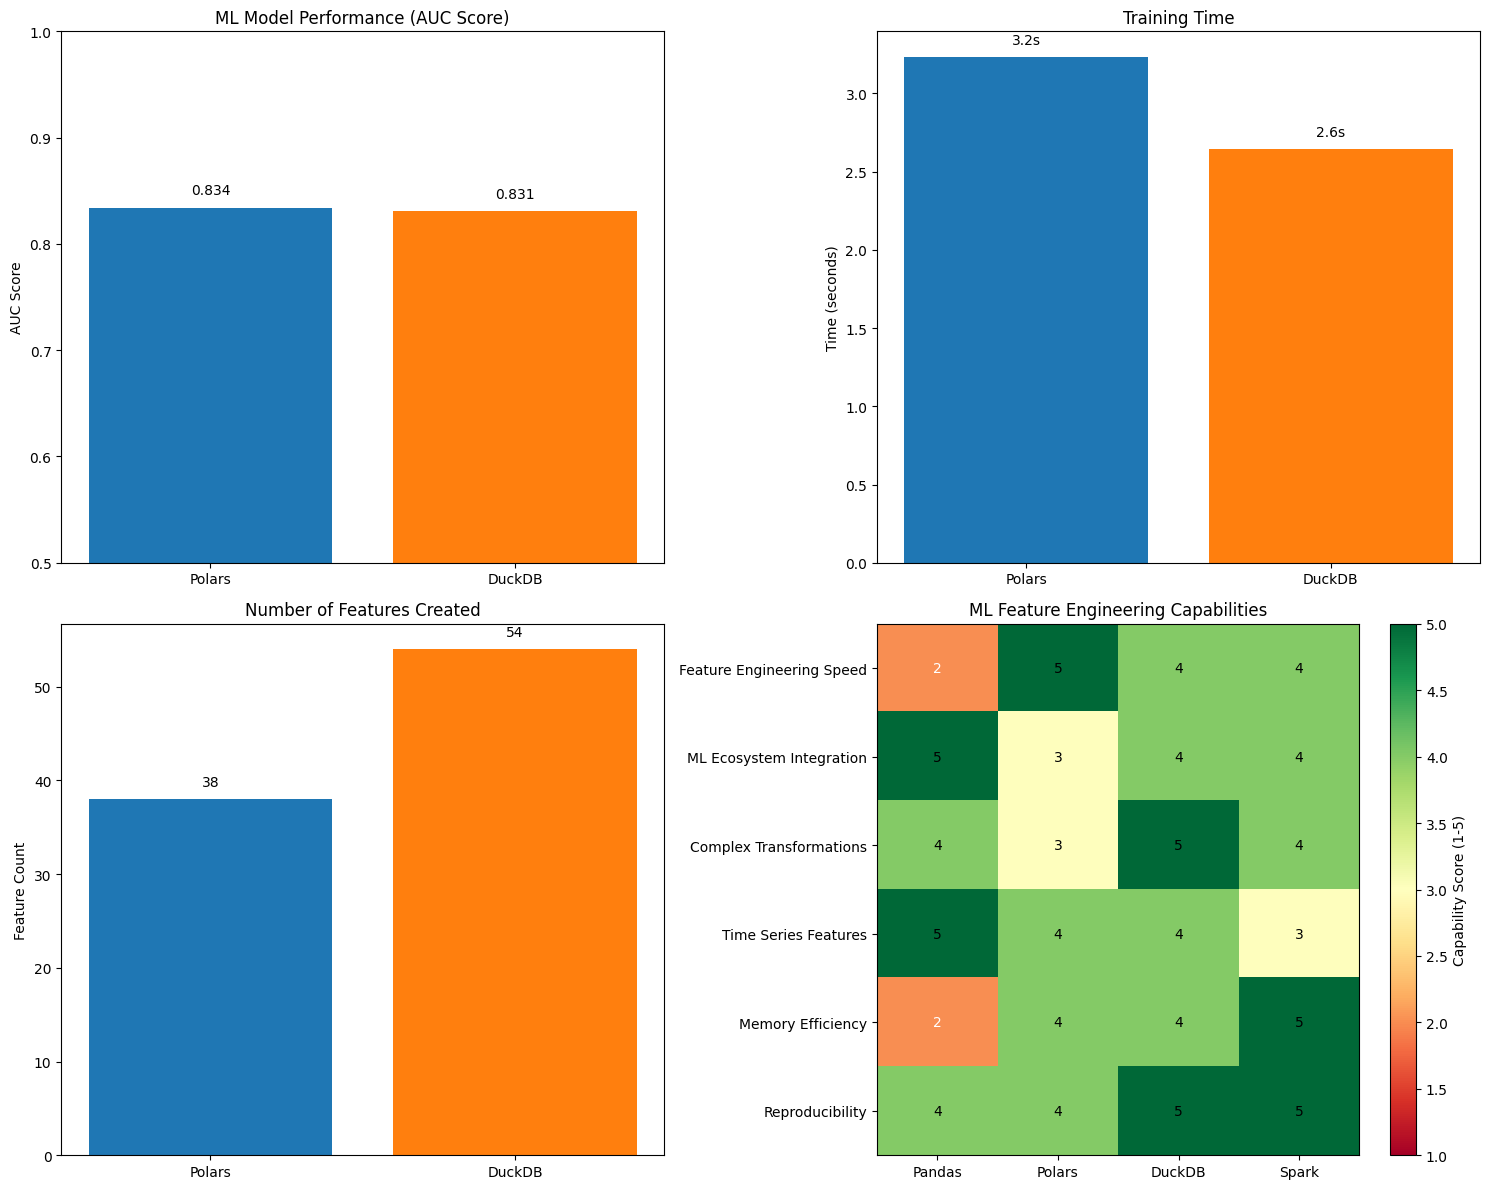

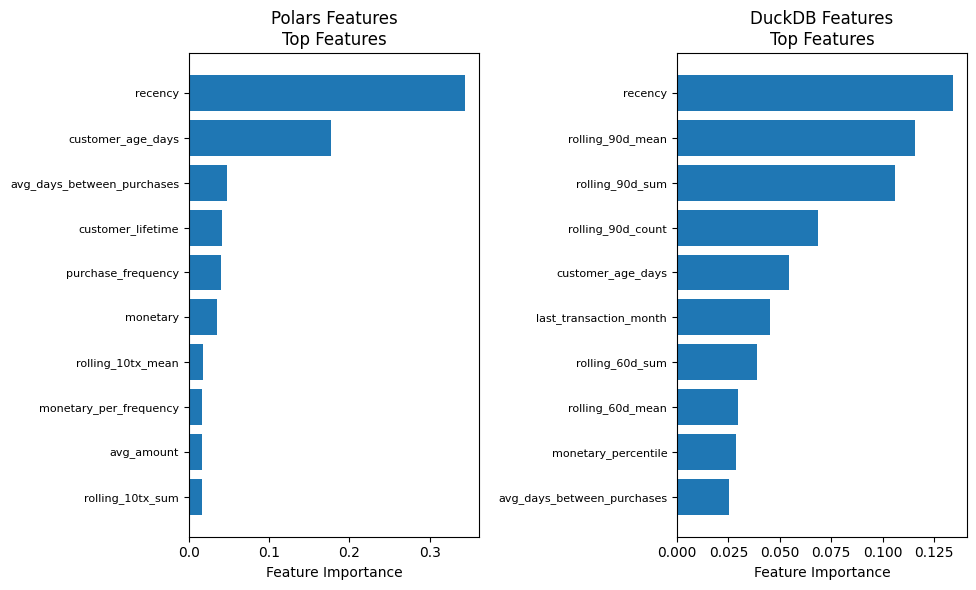


=== SCENARIO 4 CONCLUSIONS ===

🏆 WINNER: Pandas for Rapid ML Prototyping
   - Unmatched ecosystem integration with scikit-learn, XGBoost, etc.
   - Flexible APIs for complex feature transformations
   - Extensive time series functionality
   - Rich visualization and debugging capabilities
   - Seamless integration with Jupyter notebooks

🥈 RUNNER-UP: DuckDB for Complex SQL-based Features
   - Excellent for complex analytical feature engineering
   - SQL expressiveness for window functions and aggregations
   - Easy integration with pandas for ML workflows
   - Great for features that are hard to express in DataFrame APIs

🚀 Polars: High-Performance Feature Computation
   - Excellent performance for large-scale feature engineering
   - Memory-efficient processing
   - Often requires conversion to pandas for ML ecosystem
   - Growing ML integration but still limited

⚡ Spark: Production ML Pipelines at Scale
   - Best for large-scale production ML feature pipelines
   - MLlib integrati

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Performance visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

if ml_results:
    # 1. Model Performance Comparison
    tools = [r['model_name'].replace(' Features', '') for r in ml_results]
    auc_scores = [r['auc_score'] for r in ml_results]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(tools)]

    bars1 = ax1.bar(tools, auc_scores, color=colors)
    ax1.set_title('ML Model Performance (AUC Score)')
    ax1.set_ylabel('AUC Score')
    ax1.set_ylim(0.5, 1.0)

    for bar, score in zip(bars1, auc_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom')

    # 2. Feature Engineering Time
    # Note: We'd need to track feature engineering times separately
    # For now, we'll use training times as a proxy
    training_times = [r['training_time'] for r in ml_results]
    bars2 = ax2.bar(tools, training_times, color=colors)
    ax2.set_title('Training Time')
    ax2.set_ylabel('Time (seconds)')

    for bar, time in zip(bars2, training_times):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.02,
                f'{time:.1f}s', ha='center', va='bottom')

    # 3. Number of Features Created
    n_features = [r['n_features'] for r in ml_results]
    bars3 = ax3.bar(tools, n_features, color=colors)
    ax3.set_title('Number of Features Created')
    ax3.set_ylabel('Feature Count')

    for bar, count in zip(bars3, n_features):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(n_features)*0.02,
                f'{count}', ha='center', va='bottom')

# 4. ML Feature Engineering Capability Matrix
capability_data = {
    'Tool': ['Pandas', 'Polars', 'DuckDB', 'Spark'],
    'Feature Engineering Speed': [2, 5, 4, 4],
    'ML Ecosystem Integration': [5, 3, 4, 4],
    'Complex Transformations': [4, 3, 5, 4],
    'Time Series Features': [5, 4, 4, 3],
    'Memory Efficiency': [2, 4, 4, 5],
    'Reproducibility': [4, 4, 5, 5]
}

capability_df = pd.DataFrame(capability_data)
capability_matrix = capability_df.set_index('Tool').T

im = ax4.imshow(capability_matrix.values, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)
ax4.set_xticks(range(len(capability_matrix.columns)))
ax4.set_xticklabels(capability_matrix.columns)
ax4.set_yticks(range(len(capability_matrix.index)))
ax4.set_yticklabels(capability_matrix.index)
ax4.set_title('ML Feature Engineering Capabilities')

# Add text annotations
for i in range(len(capability_matrix.index)):
    for j in range(len(capability_matrix.columns)):
        ax4.text(j, i, capability_matrix.iloc[i, j], ha='center', va='center',
                color='white' if capability_matrix.iloc[i, j] < 3 else 'black')

plt.colorbar(im, ax=ax4, label='Capability Score (1-5)')
plt.tight_layout()
plt.show()

# Feature importance comparison
if len(ml_results) >= 2:
    fig, axes = plt.subplots(1, len(ml_results), figsize=(5*len(ml_results), 6))
    if len(ml_results) == 1:
        axes = [axes]

    for i, result in enumerate(ml_results):
        top_features = result['feature_importance'].head(10)
        axes[i].barh(range(len(top_features)), top_features['importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['feature'], fontsize=8)
        axes[i].set_title(f'{result["model_name"]}\nTop Features')
        axes[i].set_xlabel('Feature Importance')
        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

print("\n=== SCENARIO 4 CONCLUSIONS ===")
print("\n🏆 WINNER: Pandas for Rapid ML Prototyping")
print("   - Unmatched ecosystem integration with scikit-learn, XGBoost, etc.")
print("   - Flexible APIs for complex feature transformations")
print("   - Extensive time series functionality")
print("   - Rich visualization and debugging capabilities")
print("   - Seamless integration with Jupyter notebooks")

print("\n🥈 RUNNER-UP: DuckDB for Complex SQL-based Features")
print("   - Excellent for complex analytical feature engineering")
print("   - SQL expressiveness for window functions and aggregations")
print("   - Easy integration with pandas for ML workflows")
print("   - Great for features that are hard to express in DataFrame APIs")

print("\n🚀 Polars: High-Performance Feature Computation")
print("   - Excellent performance for large-scale feature engineering")
print("   - Memory-efficient processing")
print("   - Often requires conversion to pandas for ML ecosystem")
print("   - Growing ML integration but still limited")

print("\n⚡ Spark: Production ML Pipelines at Scale")
print("   - Best for large-scale production ML feature pipelines")
print("   - MLlib integration for distributed ML")
print("   - Built-in feature transformers and pipelines")
print("   - Overkill for exploratory feature engineering")

print("\n📊 Key Insights:")
print("   - Pandas remains king for ML prototyping and experimentation")
print("   - DuckDB excels at creating complex analytical features")
print("   - Polars is great for performance but needs pandas bridge")
print("   - Spark is essential for production ML at enterprise scale")
print("   - Hybrid approaches often work best in practice")

In [11]:
# Summary of all scenarios
print("\n" + "="*60)
print("COMPREHENSIVE DATA PROCESSING TOOL COMPARISON SUMMARY")
print("="*60)

print("\n📊 SCENARIO WINNERS:")
print("   1. Jupyter Notebook Data Scientist → DuckDB/Polars")
print("   2. Production ETL Pipeline → Spark")
print("   3. Real-Time Analytics Dashboard → DuckDB")
print("   4. ML Feature Pipeline → Pandas")

print("\n🎯 TOOL RECOMMENDATIONS BY USE CASE:")
print("\n   🐼 Choose PANDAS when:")
print("      • Rapid prototyping and experimentation")
print("      • Complex ML feature engineering")
print("      • Rich ecosystem integration needed")
print("      • Data fits in memory (<5GB)")

print("\n   🐻‍❄️ Choose POLARS when:")
print("      • Performance is critical")
print("      • Memory efficiency matters")
print("      • Data processing workloads (5-100GB)")
print("      • Team can invest in learning new APIs")

print("\n   🦆 Choose DUCKDB when:")
print("      • Analytical queries and dashboards")
print("      • SQL-first approach preferred")
print("      • Complex aggregations and window functions")
print("      • Single-machine analytical workloads")

print("\n   ⚡ Choose SPARK when:")
print("      • Production ETL at scale (>100GB)")
print("      • Distributed processing required")
print("      • Enterprise fault tolerance needed")
print("      • Existing big data infrastructure")

print("\n🔄 HYBRID APPROACHES:")
print("   • Use Spark for ETL → DuckDB for analytics")
print("   • Use Polars for processing → Pandas for ML")
print("   • Use DuckDB for features → Pandas for modeling")
print("   • Use multiple tools in the same pipeline")

print("\n💡 FINAL ADVICE:")
print("   The 'best' tool depends on your constraints, not just data size.")
print("   Consider: team skills, infrastructure, performance needs,")
print("   ecosystem requirements, and maintenance overhead.")
print("   Don't be afraid to use multiple tools together!")

print("\n" + "="*60)


COMPREHENSIVE DATA PROCESSING TOOL COMPARISON SUMMARY

📊 SCENARIO WINNERS:
   1. Jupyter Notebook Data Scientist → DuckDB/Polars
   2. Production ETL Pipeline → Spark
   3. Real-Time Analytics Dashboard → DuckDB
   4. ML Feature Pipeline → Pandas

🎯 TOOL RECOMMENDATIONS BY USE CASE:

   🐼 Choose PANDAS when:
      • Rapid prototyping and experimentation
      • Complex ML feature engineering
      • Rich ecosystem integration needed
      • Data fits in memory (<5GB)

   🐻‍❄️ Choose POLARS when:
      • Performance is critical
      • Memory efficiency matters
      • Data processing workloads (5-100GB)
      • Team can invest in learning new APIs

   🦆 Choose DUCKDB when:
      • Analytical queries and dashboards
      • SQL-first approach preferred
      • Complex aggregations and window functions
      • Single-machine analytical workloads

   ⚡ Choose SPARK when:
      • Production ETL at scale (>100GB)
      • Distributed processing required
      • Enterprise fault tolerance nee